### Task 10: Add Constant Product Trading interest rate as continuous rebase
* https://cryptorating.eu/whitepapers/Aave/aave-v2-whitepaper.pdf

In [1]:
import os
import copy
import numpy as np
import time
import matplotlib.pyplot as plt
cwd =  os.getcwd().replace("notebooks/test","")
os.chdir(cwd)

from python.dev.event.state.series import StateSeries
from python.dev.event.state import State
from python.dev.event import Deposit
from python.dev.event import Withdraw
from python.dev.token.trade import Convert
from python.dev.cpt import Liquidity
from python.dev.cpt import PriceCurve
from python.dev.cpt import ConstantProductTrade
from python.dev.plot import PlotPriceCurve
from python.dev.token import RebaseToken
from python.dev.math.model import TimeDeltaModel
from python.dev.math.model import TokenDeltaModel
from python.dev.math.model import EventSelectionModel

In [2]:
time0 = time.time()

In [3]:
APY = 0.1
state = State(Deposit(0,0,0))
state.init_first_state(time0)
state_series = StateSeries()

for k in range(320):
    delta = TokenDeltaModel(1,10).apply()  
    select = EventSelectionModel().bi_select(0.7)
    t_delta = TimeDeltaModel().apply()
      
    if(select == EventSelectionModel().FIRST): 
        event = Deposit(APY,delta,t_delta)
    else:
        event = Withdraw(APY,delta,t_delta)  

    state.update_event(event)
    state_series.add_state(state)
    

principle = state_series.get_principle() 
balance = state_series.get_balance() 
tSamp = state_series.get_tstamp()

In [4]:
for k in range(10):
    type_event = state_series.get_state(k).get_event().type_of()
    print('{}: {} @ {}'.format(k, type_event, tSamp[k]))

0: DEPOSIT @ 2022-04-28 16:19:54.497694
1: DEPOSIT @ 2022-04-29 15:02:50.497694
2: WITHDRAW @ 2022-05-02 03:28:58.497694
3: WITHDRAW @ 2022-05-02 17:44:53.497694
4: WITHDRAW @ 2022-05-04 16:57:29.497694
5: DEPOSIT @ 2022-05-04 18:27:32.497694
6: WITHDRAW @ 2022-05-04 21:28:19.497694
7: DEPOSIT @ 2022-05-06 03:23:13.497694
8: DEPOSIT @ 2022-05-06 04:33:19.497694
9: DEPOSIT @ 2022-05-08 03:07:29.497694


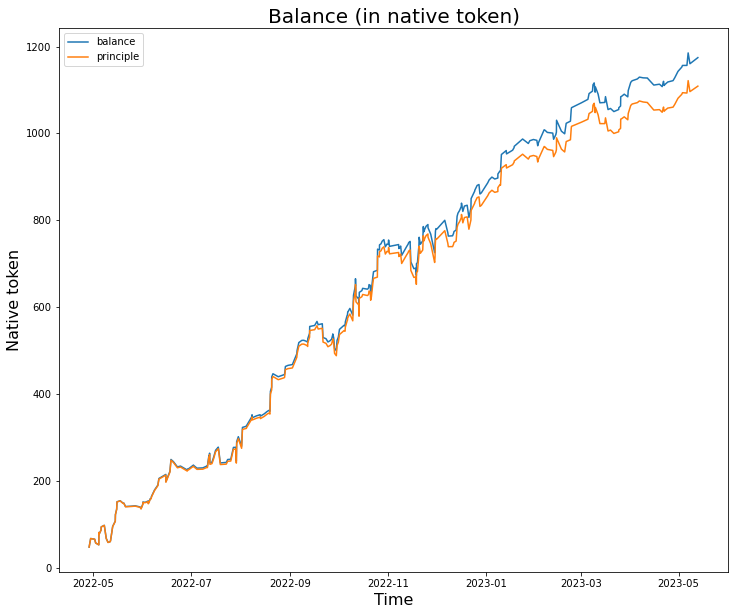

In [5]:
import matplotlib.pyplot as plt

fig, (balance_ax) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(12, 10))

balance_ax.plot(tSamp, balance, label='balance') 
balance_ax.plot(tSamp, principle, label='principle') 

balance_ax.set_title("Balance (in native token)", fontsize=20)
balance_ax.set_ylabel("Native token", fontsize=16)
balance_ax.set_xlabel('Time', fontsize=16)
balance_ax.legend()


In [6]:
# Initialize Test Tokens

TYPE_DEPOSIT_TOKEN = 'DEPOSIT'
TYPE_DEBT_TOKEN = 'DEBT'

t_delta = TimeDeltaModel().apply()
depositT1 = TokenDeltaModel(2,20000).apply() 

T1 = RebaseToken(TYPE_DEPOSIT_TOKEN)
t1Address = T1.gen_address()
T1.init_token(time0, t1Address)
T1.add_event(Deposit(APY, depositT1, t_delta, t1Address))

t_delta = TimeDeltaModel().apply()
depositTDT = TokenDeltaModel(2,20000).apply() 

TDT = RebaseToken(TYPE_DEBT_TOKEN)
tdtAddress = TDT.gen_address()
TDT.init_token(time0, tdtAddress)
TDT.add_event(Deposit(APY, depositTDT, t_delta, tdtAddress))

x = T1.get_balance_deposits()
y = TDT.get_balance_deposits()

print('[Initial] T1: {:.2f} TDT: {:.2f}\n'.format(x,y))

[Initial] T1: 10000.00 TDT: 10000.00



In [7]:
# Initialize Liquidity Pool
liq = Liquidity(x,y)
L = liq.calc(); #p = np.random.normal(5,0.1,1)[0]
p = liq.get_swap_price()
cpt = ConstantProductTrade(L)
pCurve = PriceCurve(L)

[Trade 0] T1: 9919.31248 TDT: 10081.08135 L: 10000.19692
[Trade 0] T1_prin: 9919.11557 T1_balance: 9919.31248
[Trade 0] TDT_prin: 10080.88443 TDT_balance: 10081.08135

[Trade 50] T1: 8866.60035 TDT: 11406.97686 L: 10137.73642
[Trade 50] T1_prin: 8737.14719 T1_balance: 8866.60035
[Trade 50] TDT_prin: 11262.85281 TDT_balance: 11406.97686

[Trade 100] T1: 9446.73899 TDT: 11110.56237 L: 10282.88155
[Trade 100] T1_prin: 9193.59712 T1_balance: 9446.73899
[Trade 100] TDT_prin: 10806.40288 TDT_balance: 11110.56237

[Trade 150] T1: 10359.49571 TDT: 10500.41755 L: 10436.63285
[Trade 150] T1_prin: 9971.80741 T1_balance: 10359.49571
[Trade 150] TDT_prin: 10028.19259 TDT_balance: 10500.41755

[Trade 200] T1: 8882.24627 TDT: 12397.15481 L: 10650.08694
[Trade 200] T1_prin: 8307.81046 T1_balance: 8882.24627
[Trade 200] TDT_prin: 11692.18954 TDT_balance: 12397.15481



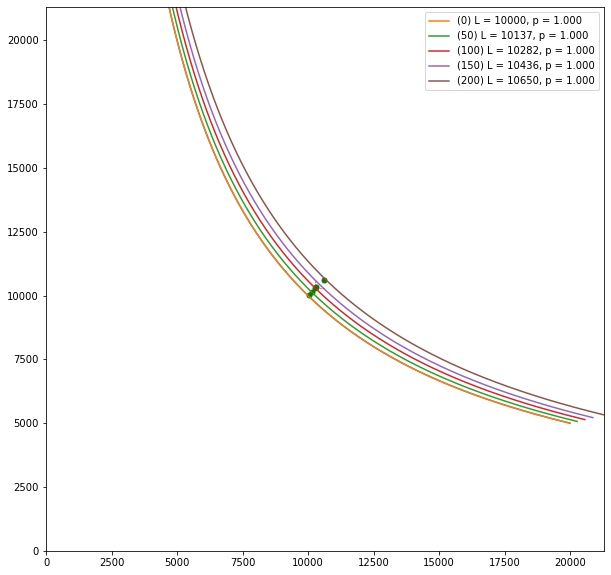

In [8]:
# Plot and execute N trades
percent = 0.05
N = 250

plotCurve = PlotPriceCurve(L, cpt, pCurve)
plotCurve.apply(p, None)

for k in range(N):
    # Generate random delta denomenated in Native token, 
    # rebalance respective accounts and convert to T1
    delta_x = TokenDeltaModel(1,100).apply() 
    t_delta = TimeDeltaModel().apply()

    select = EventSelectionModel().bi_select(0.5)
    if(select == EventSelectionModel().FIRST): 
        T1.add_event(Withdraw(APY, delta_x, t_delta, t1Address))
        TDT.add_event(Deposit(APY, delta_x, t_delta, tdtAddress)) 
    else:            
        T1.add_event(Deposit(APY, delta_x, t_delta, t1Address))
        TDT.add_event(Withdraw(APY, delta_x, t_delta, tdtAddress))
        delta_x = -delta_x
    
    TDT_yield = TDT.get_state_series(tdtAddress).get_state(k).get_yield()
    T1_yield = T1.get_state_series(t1Address).get_state(k).get_yield()
    
    liq.delta_y(TDT_yield)
    liq.delta_x(T1_yield) 
    
    x = T1.get_balance_deposits()
    y = TDT.get_balance_deposits()    
    
    L = liq.swap(delta_x); # p = np.random.normal(5,0.1,1)[0]
    p = liq.get_swap_price()
    if (k % int(N/(100*percent)) == 0):
        plotCurve.apply_next(p, L, '({}) L = {}, p = {:.3f}'.format(k, int(L),p))
        plotCurve.plot_trade(p, delta_x, 'r--')
        T1_prin = T1.get_state_series(t1Address).get_state(k).get_principle()
        T1_balance = T1.get_state_series(t1Address).get_state(k).get_balance()

        TDT_prin = TDT.get_state_series(tdtAddress).get_state(k).get_principle()
        TDT_balance = TDT.get_state_series(tdtAddress).get_state(k).get_balance()
            
        print('[Trade {}] T1: {:.5f} TDT: {:.5f} L: {:.5f}'.format(k, x,y,L))
        print('[Trade {}] T1_prin: {:.5f} T1_balance: {:.5f}'.format(k, T1_prin,T1_balance))
        print('[Trade {}] TDT_prin: {:.5f} TDT_balance: {:.5f}\n'.format(k, TDT_prin,TDT_balance))
      




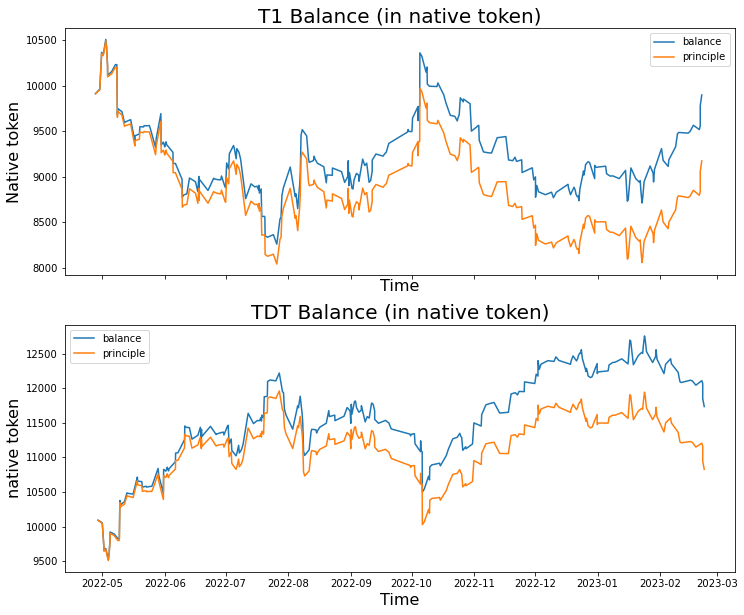

In [9]:
# Analyze Token balances

T1_states = T1.get_state_series(t1Address)
principle = T1_states.get_principle() 
balance = T1_states.get_balance() 
tSamp = T1_states.get_tstamp()  

fig, (T1_ax, TDT_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))

T1_ax.plot(tSamp[1:], balance[1:], label='balance') 
T1_ax.plot(tSamp[1:], principle[1:], label='principle') 
T1_ax.set_title("T1 Balance (in native token)", fontsize=20)
T1_ax.set_ylabel("Native token", fontsize=16)
T1_ax.set_xlabel('Time', fontsize=16)
T1_ax.legend()

TDT_states = TDT.get_state_series(tdtAddress)
principle = TDT_states.get_principle() 
balance = TDT_states.get_balance() 
tSamp = TDT_states.get_tstamp() 

TDT_ax.plot(tSamp[1:], balance[1:], label='balance') 
TDT_ax.plot(tSamp[1:], principle[1:], label='principle') 
TDT_ax.set_title("TDT Balance (in native token)", fontsize=20)
TDT_ax.set_ylabel("native token", fontsize=16)
TDT_ax.set_xlabel('Time', fontsize=16)
TDT_ax.legend()
